#  Titanic - Machine Learning from Disaster
### The objective of this lab is to apply machine learning techniques to the Titanic dataset to predict passenger survival

In [41]:
# importing necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
from sklearn.impute import SimpleImputer
import warnings
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt


warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

In [42]:
def wrangle(filepath):
    """
    This function reads a CSV file containing Titanic passenger data, performs data cleaning and feature engineering,
    and returns a processed DataFrame.

    Parameters:
    filepath (str): The path to the CSV file containing the Titanic passenger data.

    Returns:
    pandas.DataFrame: A DataFrame with the following columns: 'PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'Fare', 'Family'.
    The 'Family' column is created by summing 'SibSp' and 'Parch' columns.
    Missing values in the 'Age' column are filled with the median value.
    """
    # Import CSV
    df = pd.read_csv(filepath)
    
    # Drop columns
    df = df.drop(columns=['Name', 'Ticket', 'Cabin','PassengerId'])
    
    # feature creation
    df['Family'] = df['SibSp'] + df['Parch']
    
    # Drop columns
    df = df.drop(columns=['SibSp', 'Parch'])
    
    # Create an imputer object with a strategy to fill missing values with the median
    imputer = SimpleImputer(strategy='median')
    df['Age'] = imputer.fit_transform(df[['Age']])
    df['Age'] = df['Age'].astype(int)
    
    return df

    

## Task 1: Data Exploration and Visualization

In [43]:
# Load the train dataset
train_data = wrangle("titanic_data/train.csv")
train_data.head(10)

,Pclass,Sex,Age,Fare,Embarked,Survived,Family
0,3,male,28,56.4958,S,1,0
1,2,male,28,0.0000,S,0,0
2,1,male,28,221.7792,S,0,0
3,3,female,18,9.3500,S,1,1
4,2,female,31,26.2500,S,1,2
5,3,male,21,8.4333,S,0,0
6,3,male,26,56.4958,S,1,0
7,1,male,28,227.5250,C,0,0
8,3,male,28,7.7500,Q,1,0
9,3,female,31,18.0000,S,0,1


In [44]:
# Viewing the statistical values of the training data
train_data.describe(include="all")

,Pclass,Sex,Age,Fare,Embarked,Survived,Family
count,712.000000,712,712.000000,712.000000,710,712.000000,712.000000
unique,NaN,2,NaN,NaN,3,NaN,NaN
top,NaN,male,NaN,NaN,S,NaN,NaN
freq,NaN,459,NaN,NaN,516,NaN,NaN
mean,2.308989,NaN,29.443820,31.819826,NaN,0.383427,0.883427
std,0.833563,NaN,13.043029,48.059104,NaN,0.486563,1.589047
min,1.000000,NaN,0.000000,0.000000,NaN,0.000000,0.000000
25%,2.000000,NaN,22.000000,7.895800,NaN,0.000000,0.000000
50%,3.000000,NaN,28.000000,14.454200,NaN,0.000000,0.000000
75%,3.000000,NaN,36.000000,31.000000,NaN,1.000000,1.000000


In [45]:
# View the data types and non-null count of the training data
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 712 entries, 0 to 711
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    712 non-null    int64  
 1   Sex       712 non-null    object 
 2   Age       712 non-null    int32  
 3   Fare      712 non-null    float64
 4   Embarked  710 non-null    object 
 5   Survived  712 non-null    int64  
 6   Family    712 non-null    int64  
dtypes: float64(1), int32(1), int64(3), object(2)
memory usage: 36.3+ KB


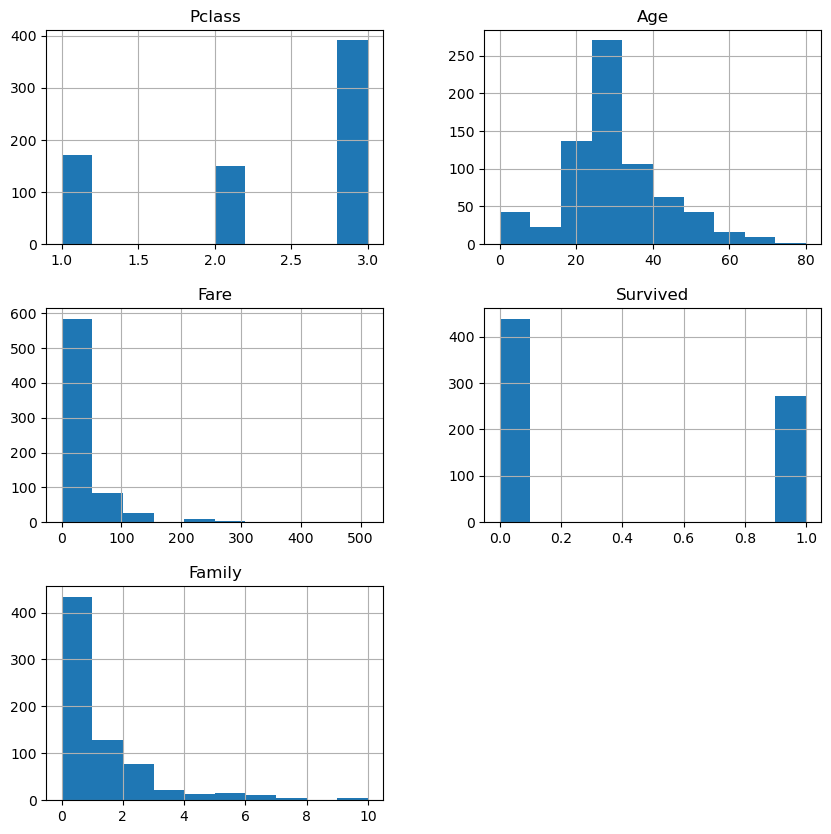

In [46]:
# Visualizing the distribution of the training data
train_data.hist(figsize=(10,10));

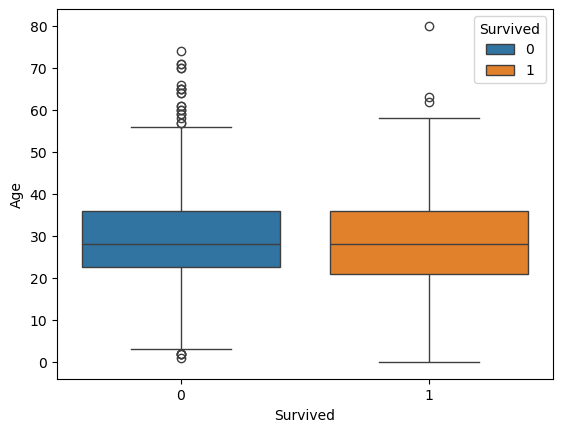

In [47]:
# Visualizing the relationships between the age and the survived column
sns.boxplot(x ='Survived',y='Age',hue='Survived', data=train_data);

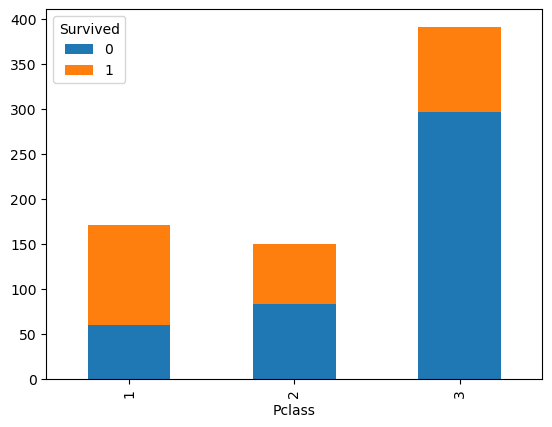

In [48]:
# Visualizing the relationships between the class and the survived column
crosstab = pd.crosstab(train_data['Pclass'], train_data['Survived'])

# Plot the stacked bar plot
crosstab.plot(kind='bar', stacked=True)
plt.show()

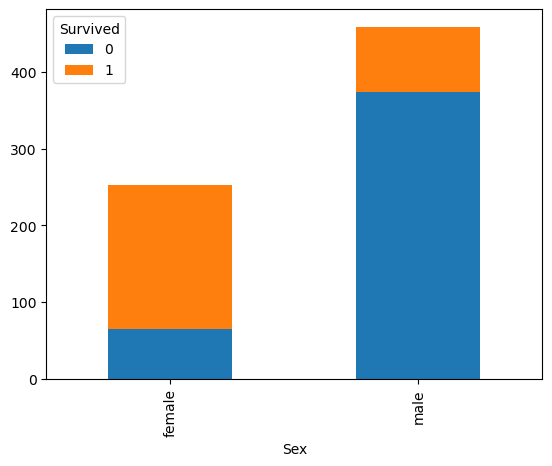

In [49]:
# Visualizing the relationships between the gender and the survived column
# Create a cross-tabulation
crosstab = pd.crosstab(train_data['Sex'], train_data['Survived'])

# Plot the stacked bar plot
crosstab.plot(kind='bar', stacked=True)
plt.show()


## Task 2: Data Cleaning and Preprocessing

In [50]:
# Checking for missing data
train_data.isnull().sum()

Pclass      0
Sex         0
Age         0
Fare        0
Embarked    2
Survived    0
Family      0
dtype: int64

In [51]:
# Fill null values in the 'Embarked' column with the mode
train_data['Embarked'].fillna(train_data['Embarked'].mode()[0], inplace=True)

In [52]:
# Instantiate a label encoder object
le = LabelEncoder()

In [53]:
# Encoding object data types in train_data
for col in train_data.select_dtypes('object'):
    train_data[col] = le.fit_transform(train_data[col])

In [54]:
# Apply log transformation to fix skewness in the 'Fare' column
#train_data['Fare'] = np.log1p(train_data['Fare'])


In [55]:
# # Calculate Q1 (25th percentile) and Q3 (75th percentile)
# Q1 = train_data['Age'].quantile(0.25)
# Q3 = train_data['Age'].quantile(0.75)

# # Calculate the Interquartile Range (IQR)
# IQR = Q3 - Q1

# # Define the lower and upper bounds for outliers
# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR

# # Filter out the outliers
# train_data = train_data[(train_data['Age'] >= lower_bound) & (train_data['Age'] <= upper_bound)]

In [56]:
# Spilt the train data to features and target
X = train_data.drop(columns=['Survived'])
y = train_data['Survived']

In [57]:
# Instantiate the standard scaler 
scaler = StandardScaler()

In [58]:
# Applying Standardization to the features
X = scaler.fit_transform(X)

In [59]:
# Splitting the train data into train and validation sets
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.2,random_state=42)

## Task 3: Feature Engineering 

In [60]:
# Pearson correlation matrix on training data
corr = train_data.corr(method='pearson')

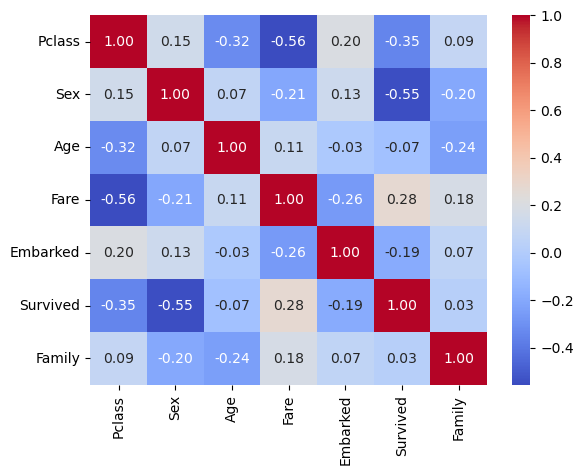

In [61]:
# Plot a heatmap of the correlation matrix
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f");

## Task 4: Model Selection and Training

In [84]:
# Create a pipeline with an imputer, scaler, and the model
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    
    #('model', RandomForestClassifier(random_state=42)) # RandomForestClassifier accuracy: 0.77
    
    #('model', SVC()) # Support Vector Machine accuracy: 0.80
    
    # ('model', LogisticRegression()) # Logistic Regression accuracy: 0.77
    
    #('model', KNeighborsClassifier()) # KNeighborsClassifier accuracy: 0.78
    
    ('model', GradientBoostingClassifier(random_state=42)) # GradientBoostingClassifier accuracy: 0.77
    
])


In [85]:
# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('model', GradientBoostingClassifier(random_state=42))])

In [86]:
# Evaluate the pipeline on the test data
pipeline.score(X_val, y_val)

0.8111888111888111

In [87]:
# Making predictions on the validation data
y_pred = pipeline.predict(X_val)

In [88]:
# Printing the confusion matrix
conf = confusion_matrix(y_val, y_pred)
print(conf)

[[76  8]
 [19 40]]


In [89]:
# Extracting TP, TN, FP, FN from the confusion matrix
tn, fp, fn, tp = conf.ravel()

print(f"True Positives (TP): {tp}")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")

True Positives (TP): 40
True Negatives (TN): 76
False Positives (FP): 8
False Negatives (FN): 19


In [90]:
# Perform cross-validation
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')

# Print the cross-validation scores and the mean score
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())

Cross-validation scores: [0.75438596 0.84210526 0.83333333 0.84210526 0.88495575]
Mean cross-validation score: 0.8313771153547587


In [91]:
report = classification_report(y_val, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.80      0.90      0.85        84
           1       0.83      0.68      0.75        59

    accuracy                           0.81       143
   macro avg       0.82      0.79      0.80       143
weighted avg       0.81      0.81      0.81       143



## Task 5: Model Optimization 

In [ ]:
# Define the parameter grid for GradientBoostingClassifier
param_grid_gb = {
    'model__n_estimators': [50, 100, 200],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__max_depth': [3, 4, 5],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

# Update the pipeline with GradientBoostingClassifier
pipeline.set_params(model=GradientBoostingClassifier(random_state=42))

# Instantiate the GridSearchCV object
grid_search_gb = GridSearchCV(pipeline, param_grid_gb, cv=5, scoring='accuracy')

# Fit the grid search to the training data
grid_search_gb.fit(X_train, y_train)

# Get the best parameters and best score
best_params_gb = grid_search_gb.best_params_
best_score_gb = grid_search_gb.best_score_

print("Best Parameters for GradientBoostingClassifier:", best_params_gb)
print("Best Cross-Validation Score for GradientBoostingClassifier:", best_score_gb)

In [70]:
# Define the parameter grid for RandomForestClassifier
param_grid_rf = {
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [3, 4, 5],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

# Update the pipeline with RandomForestClassifier
pipeline.set_params(model=RandomForestClassifier(random_state=42))

# Instantiate the GridSearchCV object
grid_search_rf = GridSearchCV(pipeline, param_grid_rf, cv=5, scoring='accuracy')

# Fit the grid search to the training data
grid_search_rf.fit(X_train, y_train)

# Get the best parameters and best score
best_params_rf = grid_search_rf.best_params_
best_score_rf = grid_search_rf.best_score_

print("Best Parameters for RandomForestClassifier:", best_params_rf)
print("Best Cross-Validation Score for RandomForestClassifier:", best_score_rf)

Best Parameters for RandomForestClassifier: {'model__max_depth': 5, 'model__min_samples_leaf': 2, 'model__min_samples_split': 10, 'model__n_estimators': 200}
Best Cross-Validation Score for RandomForestClassifier: 0.8383636081353828


In [71]:
# Update the pipeline with the best parameters for Support Vector Machine
pipeline.set_params(**best_params_gb)

# Fit the updated pipeline on the training data
pipeline.fit(X_train, y_train)

# Make predictions on the validation set
y_pred = pipeline.predict(X_val)

# Evaluate the updated pipeline
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy:", accuracy)

# Print the classification report
report = classification_report(y_val, y_pred)
print(report)

Accuracy: 0.7902097902097902
              precision    recall  f1-score   support

           0       0.76      0.93      0.84        84
           1       0.85      0.59      0.70        59

    accuracy                           0.79       143
   macro avg       0.81      0.76      0.77       143
weighted avg       0.80      0.79      0.78       143



## Task 6: Testing and Submission

In [72]:
# Importing the test data 
test_data = wrangle("titanic_data/test.csv")
test_data.head(10)

,Pclass,Sex,Age,Fare,Embarked,Family
0,3,male,24,24.1500,S,2
1,3,male,44,16.1000,S,1
2,3,male,22,7.2250,C,0
3,3,male,41,14.1083,S,2
4,3,female,27,15.5000,Q,1
5,3,female,36,17.4000,S,1
6,2,female,36,13.0000,S,0
7,1,male,45,26.5500,S,0
8,1,male,49,110.8833,C,2
9,2,male,34,26.0000,S,1


In [73]:
# Checking for missing data in the test data
test_data.isnull().sum()

Pclass      0
Sex         0
Age         0
Fare        0
Embarked    0
Family      0
dtype: int64

In [74]:
# Encoding object data types in test_data
for col in test_data.select_dtypes('object'):
    test_data[col] = le.fit_transform(test_data[col])

In [75]:
# Viewing data types in test_data
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179 entries, 0 to 178
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    179 non-null    int64  
 1   Sex       179 non-null    int32  
 2   Age       179 non-null    int32  
 3   Fare      179 non-null    float64
 4   Embarked  179 non-null    int32  
 5   Family    179 non-null    int64  
dtypes: float64(1), int32(3), int64(2)
memory usage: 6.4 KB


In [76]:
# Apply the same transformations to the test data
X_test = scaler.transform(test_data)

# Make predictions on the test data
test_predictions = pipeline.predict(X_test)

In [77]:
# Create a DataFrame from the test_predictions
submission = pd.DataFrame({'Survived': test_predictions})

# Save the DataFrame to a CSV file
submission.to_csv('Amoako_Heskey_submission.csv', index=False)

In [78]:
test_predictions.shape

(179,)

In [79]:
y_val.shape

(143,)

In [80]:
# Slicing the test_predictions to fit the y_val shape
sliced_test_predictions = test_predictions[:len(y_val)]

# Printing the classification report
report = classification_report(y_val, sliced_test_predictions)
print(report)

              precision    recall  f1-score   support

           0       0.61      0.80      0.69        84
           1       0.50      0.29      0.37        59

    accuracy                           0.59       143
   macro avg       0.56      0.54      0.53       143
weighted avg       0.57      0.59      0.56       143

